# Measuring Entropy in Text

Because Large Language Models (LLMs) fundamentally predict the next token, LLMs can be used as a measure of how "shocking" the next character is is pre-generated text.

This information can be useful to guide context-aware text edits. This analyzes:

- a chat gpt generated explainer on narrative economics
- an article that William wrote on the [International Science and Engineering Fair](https://www.linkedin.com/pulse/behind-innovation-insights-from-international-science-william-kaiser)

## Model Selection

[Microsoft's Phi 1.5](https://huggingface.co/microsoft/phi-1_5) model will be used. No particular reason. The model is large enough to do the job which is nice.

In [1]:
import numpy as np
import pandas as pd
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
from pathlib import Path

/u/xbk6xm/nlp-final/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/u/xbk6xm/nlp-final/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
with Path("../samples/chatgpt-narrative-economics.txt").open() as f:
    CHATGPT_TEXT = f.read()
with Path("../samples/isef-analysis.txt").open() as f:
    ISEF_TEXT = f.read()

In [3]:
torch.set_default_device("cuda")

if 'model' not in locals():
    torch.cuda.empty_cache()
    model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", dtype="auto", trust_remote_code=True)
if 'tokenizer' not in locals():
    tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

In [4]:
inputs = tokenizer(
    CHATGPT_TEXT,
    return_tensors="pt",
    return_attention_mask=False
)
inputs

Token indices sequence length is longer than the specified maximum sequence length for this model (23540 > 2048). Running this sequence through the model will result in indexing errors


{'input_ids': tensor([[   40,  1183,  6431,  ..., 34033, 29720,   220]], device='cuda:0')}

In [5]:
from math import log
from torch.amp import autocast

# zeroing grad reduces memory usage
for param in model.parameters():
    param.grad = None

def measure_losses(input_txt: str) -> tuple[float, list[float]]:
    """
    Measures the losses of a piece of text
    """
    torch.cuda.empty_cache()
    inputs = tokenizer(
        input_txt,
        return_tensors="pt",
        return_attention_mask=True
    )
    with autocast(device_type="cuda"):
        result = model.forward(**inputs)
    
    logits = result.logits
    
    new_res = torch.nn.functional.softmax(logits, dim=1)
    
    # correct
    correct_res = torch.nn.functional.one_hot(inputs.input_ids, num_classes=51_200)
    correct_res = correct_res.float()
    
    # making loss functions
    loss = torch.nn.CrossEntropyLoss()
    
    setup = loss(logits, correct_res)
    _ = setup.backward() # result is not needed
    torch.cuda.empty_cache()
    
    # iteration through each vector
    return_array = []
    num_tokens = inputs.input_ids.shape[1]
    for i in range(num_tokens):
        index = int(inputs.input_ids[0, i].cpu())
        
        res = float(new_res[0, i, index])

        # There were some numeric stability issues without this code. should be replaced eventually
        if res > 0.00000001:
            return_array.append(-1 * log(res))
        else:
            return_array.append(100)
        
    return inputs['input_ids'], return_array

isef_snippet = ISEF_TEXT[:1_000]
chatgpt_snippet = CHATGPT_TEXT[:1_000]

print("ISEF Snippet:")
print("=" * 80)
print(isef_snippet)
print("=" * 80)
print("ChatGPT Snippet:")
print("=" * 80)
print(chatgpt_snippet)
print("=" * 80)

isef_tokens, isef_entropy = measure_losses(isef_snippet)
chat_tokens, chat_entropy = measure_losses(chatgpt_snippet)

ISEF Snippet:
Science fair is likely to evoke youthful memories of creation and discovery. These formative experiences are designed to cultivate students’ interest in science, technology, engineering and mathematics. However, top-tier science fair projects are incredibly competitive. This article will look at more than 13,000 projects and:

Analyze competition background
Investigate six common pieces of competition advice
Create a interactive project visualization and search website

There are many science fair competitions, but by far the most prestigious is the International Science and Engineering Fair (ISEF). Students from over 40 countries compete to win over $9,000,000 in prize money every year. 

In 2023, the top three winners won a total of $575,000. In addition to cash awards and scholarships, ISEF is also a recruiting pool for top universities like Harvard, Stanford and MIT. 

Grand Awards Ceremony at the International Science and Engineering Fair
ISEF's grand awards ceremony

/u/xbk6xm/nlp-final/.venv/lib/python3.12/site-packages/torch/utils/_device.py:103: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return func(*args, **kwargs)


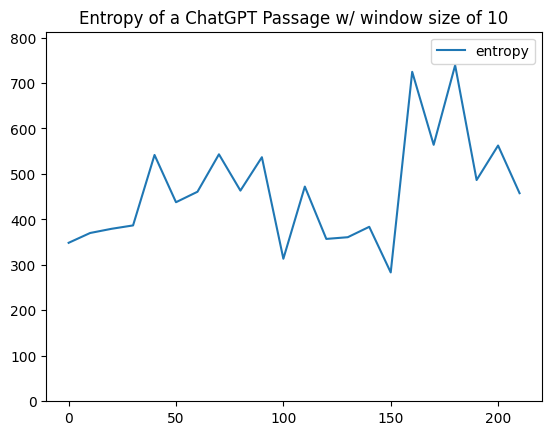

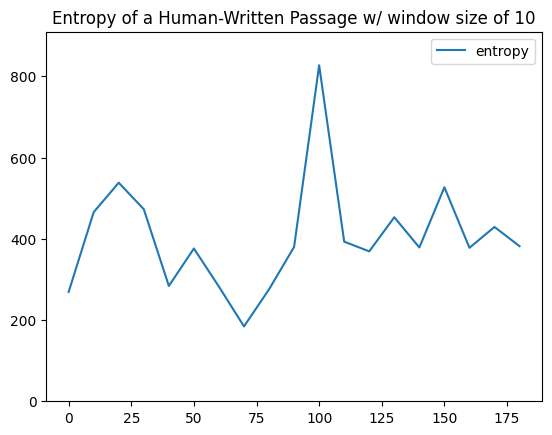

In [6]:
def sum_over_interval(entropy: list[float], window_size: int) -> list[float]:
    """
    Calculates the sum of entropy over a token window size (likely to be much more stable)
    """

    summed_entropies = []

    curr_sum = 0.0
    for idx, bits_of_info in enumerate(entropy):
        if (idx + 1) % window_size == 0:
            summed_entropies.append(curr_sum)
            curr_sum = 0

        curr_sum += bits_of_info

    return summed_entropies
    
window_size = 10
chat_entropy_totals = sum_over_interval(chat_entropy, window_size)

fig, ax = plt.subplots()
ax.plot([i * window_size for i in range(len(chat_entropy_totals))], chat_entropy_totals, label='entropy')
ax.legend()
ax.set_ylim(0, max(chat_entropy_totals) * 1.1)
ax.set_title(f"Entropy of a ChatGPT Passage w/ window size of {window_size}")
plt.show()

isef_entropy_totals = sum_over_interval(isef_entropy, window_size)

fig, ax = plt.subplots()
ax.plot([i * window_size for i in range(len(isef_entropy_totals))], isef_entropy_totals, label='entropy')
ax.legend()
ax.set_ylim(0, max(isef_entropy_totals) * 1.1)
ax.set_title(f"Entropy of a Human-Written Passage w/ window size of {window_size}")
plt.show()

In [7]:
from helpers import token_hover_widget

token_hover_widget(tokenizer, isef_snippet, add_special_tokens=True)

When examining the rolling entropy of the ISEF article, the following sentence has high entroy:

> but by far the most prestigious is the International Science and Engineering Fair ( ISE F ). Students from over 40 countries compete

To try and make the sentence flow smoother, *where* can be added.

> but by far the most prestigious is the International Science and Engineering Fair ( ISE F ) [where] students from over 40 countries compete

Then the same rolling average plots can be applied to see if this better-flowing sentence is measure-able in the entropy of the snippet.

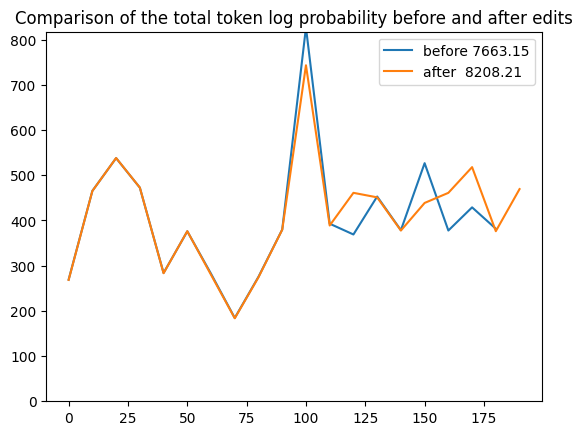

In [16]:
isef_snippet_edited = """Science fair is likely to evoke youthful memories of creation and discovery. These formative experiences are designed to cultivate students’ interest in science, technology, engineering and mathematics. However, top-tier science fair projects are incredibly competitive. This article will look at more than 13,000 projects and:

Analyze competition background
Investigate six common pieces of competition advice
Create a interactive project visualization and search website

There are many science fair competitions, but by far the most prestigious is the International Science and Engineering Fair (ISEF) where students from over 40 countries compete to win over $9,000,000 in prize money every year. 

In 2023, the top three winners won a total of $575,000. In addition to cash awards and scholarships, ISEF is also a recruiting pool for top universities like Harvard, Stanford and MIT. 

Grand Awards Ceremony at the International Science and Engineering Fair
ISEF's grand awards ceremony in 2021 where"""

isef_edited_tokens, isef_edited_entropy = measure_losses(isef_snippet_edited)
isef_snippet_edited_totals = sum_over_interval(isef_edited_entropy, window_size)

fig, ax = plt.subplots()
ax.plot([i * window_size for i in range(len(isef_entropy_totals))], isef_entropy_totals, label=f'before {sum(isef_entropy_totals):.2f}')
ax.plot([i * window_size for i in range(len(isef_snippet_edited_totals))], isef_snippet_edited_totals, label=f'after  {sum(isef_snippet_edited_totals):.2f}')
ax.legend()
ax.set_ylim(0, max(isef_snippet_edited_totals) * 1.1)
ax.set_title(f"Comparison of the total token log probability before and after edits")
plt.savefig("../figures/before-and-after-edits.png")
plt.show()

## Analyzing Computed Entropy

Do obviously discernable patterns exist in the entropy of the chatgpt generated sample.

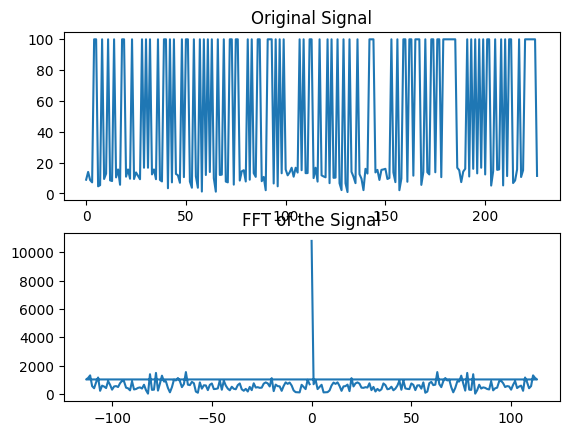

In [9]:
# running a fast fourier transform over the computed entropy
from scipy.fft import fft

# Perform FFT
fft_result = fft(chat_entropy)

# Calculate the frequency axis
freq = np.fft.fftfreq(len(fft_result), 1/len(chat_entropy))

plt.subplot(2, 1, 1)
plt.plot([i for i in range(len(chat_entropy))], chat_entropy)
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(freq, np.abs(fft_result))
plt.title('FFT of the Signal')

plt.show()

In [10]:
# marking new lines
ids = tokenizer(
    "\n",
    return_tensors="pt",
    return_attention_mask=True
).input_ids
new_line = ids[0, 0]
new_line

ids = tokenizer(
    ".",
    return_tensors="pt",
    return_attention_mask=True
).input_ids
period = ids[0, 0]

# sum(inputs.input_ids == new_line).sum()
tokenized_first_sent = tokenizer(
    CHATGPT_TEXT,
    return_tensors="pt",
    return_attention_mask=True
).input_ids
    
new_line

tensor(198, device='cuda:0')

/tmp/ipykernel_1793321/3713297419.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


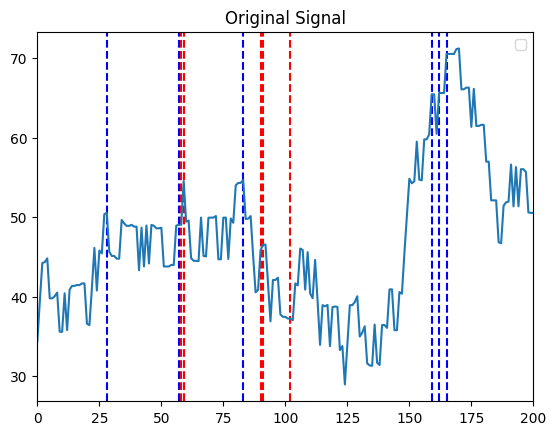

Example text: I'll gather information on the baseline theory of narrative economics, case studies that illustrate its application, and methodologies used to quantify its financial impact. Additionally, I'll explore its influence on policymaking and the role of podcasts in shaping economic narratives, particularly as a communication tool for business leaders.

I'll provide a structured summary with relevant research, case studies, and insights on how narrative economics is measured and applied. Stay tuned for the findings!

# The Baseline Theory of Narrative Economics  
**Defining Narrative Economics:** Narrative economics is the study of how popular stories and explanations – especially those with emotional resonance or moral lessons – can go viral and drive economic behavior ([Narrative Economics: How Stories Go Viral | Yale Insights](https://insights.som.yale.edu/insights/narrative-economics-how-stories-go-viral#:~:text=Narrative%20economics%2C%20as%20I%20define,with%20morals%20that%

In [11]:
# taking a rolling average of the data

kernel = np.ones(18) / 18

entropy_smoothed = np.convolve(chat_entropy, kernel, mode='valid')

j = 0
for i in tokenized_first_sent[0].cpu():
#     print(i)
    if i == new_line:
        plt.axvline(x=j, color='r', linestyle='--')
    if i == period:
        plt.axvline(x=j, color='b', linestyle='--')
    j += 1


plt.plot([i for i in range(len(entropy_smoothed))], entropy_smoothed)
plt.xlim(0, 200)
plt.legend()
plt.title('Original Signal')
plt.show()

print("Example text:", CHATGPT_TEXT[:len(CHATGPT_TEXT) // 2])

In [12]:
inputs = tokenizer(
    CHATGPT_TEXT[len(CHATGPT_TEXT) // 4:len(CHATGPT_TEXT) // 2],
    return_tensors="pt",
    return_attention_mask=True
)

print("60-100:", tokenizer.decode(inputs.input_ids[0, 180:240]))
print("200-260:", tokenizer.decode(inputs.input_ids[0, 200:260]))

60-100: /resources/education/narrative-economics#:~:text=Shiller%20uses%20the%20%E2%80%9CLaffer%20curve%E2%80%9D,cutting%20taxes%20without%20cutting
200-260: 20uses%20the%20%E2%80%9CLaffer%20curve%E2%80%9D,cutting%20taxes%20without%20cutting%20expenditures)). But a few years later, journalist Jude Wanniski turned it


In [13]:
torch.nn.functional.one_hot(inputs.input_ids, num_classes=51_200).shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.30 GiB. GPU 0 has a total capacity of 7.60 GiB of which 1.88 GiB is free. Including non-PyTorch memory, this process has 5.73 GiB memory in use. Of the allocated memory 5.30 GiB is allocated by PyTorch, and 308.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Measuring Entropy Using ZSTD

This will be measured using the compression ratio, or how much the text can be compressed.

- could potentially be inaccurate as longer pieces of text have lower entropy by default / quantization effects with the black-box algorithim which zstd is being treated as

In [ ]:
import zstd

def print_compression_ratio(input_str: str):
    compressed_result = zstd.compress(input_str.encode("utf-8"))

    print(f"Compression ratio {1 - len(compressed_result) / len(input_str)}")

print_compression_ratio("I have some sample text which I want to compress with zstd compresoin" * 20)
print_compression_ratio(CHATGPT_TEXT)